In [2]:
import sqlite3
from datetime import datetime, timedelta

# 数据库路径
db_path = "plan.db"
# 跳过几天内更新的
day_range = 7

# 获取当前日期
current_date = datetime.now().date()

# 定义 SQL 查询
select_cvalue_sql = "SELECT * FROM CValue;"
check_hcvalue_sql = """
SELECT Hdate FROM HCValue WHERE Symbol = ? ORDER BY Hdate DESC LIMIT 1;
"""
insert_hcvalue_sql = """
INSERT INTO HCValue (
    Symbol, Low_PE, High_PE, EPS, update_date, EPSY, FEPS, FFEPS, YOYGrowth, 
    FEPSupdate, Growth5Y, Growth10Y, WACC, DCF, DCFDate, Score, PE, Status, 
    LowPrice, MidPrice, HighPrice, ER_Date, Hdate
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
"""

def copy_cvalue_to_hcvalue():
    try:
        # 连接数据库
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()

            # 查询 CValue 表中的所有数据
            cursor.execute(select_cvalue_sql)
            cvalue_data = cursor.fetchall()
            cvalue_columns = [desc[0] for desc in cursor.description]  # 获取列名

            # 遍历 CValue 中的每一行数据
            for row in cvalue_data:
                symbol_data = dict(zip(cvalue_columns, row))  # 将数据转为字典
                symbol = symbol_data["Symbol"]

                # 检查 HCValue 中是否有 symbol 且日期在 7 天内的记录
                cursor.execute(check_hcvalue_sql, (symbol,))
                last_hdate = cursor.fetchone()

                if last_hdate:
                    last_hdate = datetime.strptime(last_hdate[0], "%Y-%m-%d").date()
                    if (current_date - last_hdate).days <= day_range:
                        print(f"跳过 Symbol: {symbol}, 因为它的 Hdate 在 {day_range} 天以内。")
                        continue

                # 插入数据到 HCValue 表
                insert_data = (
                    symbol_data["Symbol"], symbol_data["Low_PE"], symbol_data["High_PE"],
                    symbol_data["EPS"], symbol_data["update_date"], symbol_data["EPSY"],
                    symbol_data["FEPS"], symbol_data["FFEPS"], symbol_data["YOYGrowth"],
                    symbol_data["FEPSupdate"], symbol_data["Growth5Y"], symbol_data["Growth10Y"],
                    symbol_data["WACC"], symbol_data["DCF"], symbol_data["DCFDate"],
                    symbol_data["Score"], symbol_data["PE"], symbol_data["Status"],
                    symbol_data["LowPrice"], symbol_data["MidPrice"], symbol_data["HighPrice"],
                    symbol_data["ER_Date"], current_date.strftime("%Y-%m-%d")
                )
                cursor.execute(insert_hcvalue_sql, insert_data)
                print(f"成功复制 Symbol: {symbol} 到 HCValue。")

            # 提交更改
            conn.commit()
            print("数据复制完成。")
    except sqlite3.Error as e:
        print(f"发生错误: {e}")

# 调用函数
copy_cvalue_to_hcvalue()


成功复制 Symbol: MSFT 到 HCValue。
成功复制 Symbol: AAPL 到 HCValue。
成功复制 Symbol: PYPL 到 HCValue。
成功复制 Symbol: CAT 到 HCValue。
成功复制 Symbol: CVX 到 HCValue。
成功复制 Symbol: V 到 HCValue。
成功复制 Symbol: META 到 HCValue。
成功复制 Symbol: HON 到 HCValue。
成功复制 Symbol: UNH 到 HCValue。
成功复制 Symbol: GS 到 HCValue。
成功复制 Symbol: HD 到 HCValue。
成功复制 Symbol: WMT 到 HCValue。
成功复制 Symbol: GOOGL 到 HCValue。
成功复制 Symbol: NFLX 到 HCValue。
成功复制 Symbol: TSLA 到 HCValue。
成功复制 Symbol: FDX 到 HCValue。
成功复制 Symbol: MA 到 HCValue。
成功复制 Symbol: ILMN 到 HCValue。
成功复制 Symbol: TSM 到 HCValue。
成功复制 Symbol: CF 到 HCValue。
成功复制 Symbol: TMO 到 HCValue。
成功复制 Symbol: JNJ 到 HCValue。
成功复制 Symbol: XOM 到 HCValue。
成功复制 Symbol: BA 到 HCValue。
成功复制 Symbol: PG 到 HCValue。
成功复制 Symbol: DOW 到 HCValue。
成功复制 Symbol: VZ 到 HCValue。
成功复制 Symbol: DUK 到 HCValue。
成功复制 Symbol: ABBV 到 HCValue。
成功复制 Symbol: PM 到 HCValue。
成功复制 Symbol: BAC 到 HCValue。
成功复制 Symbol: MMM 到 HCValue。
成功复制 Symbol: MCD 到 HCValue。
成功复制 Symbol: AMGN 到 HCValue。
成功复制 Symbol: JPM 到 HCValue。
成功复制 Symbol: BLK 到 

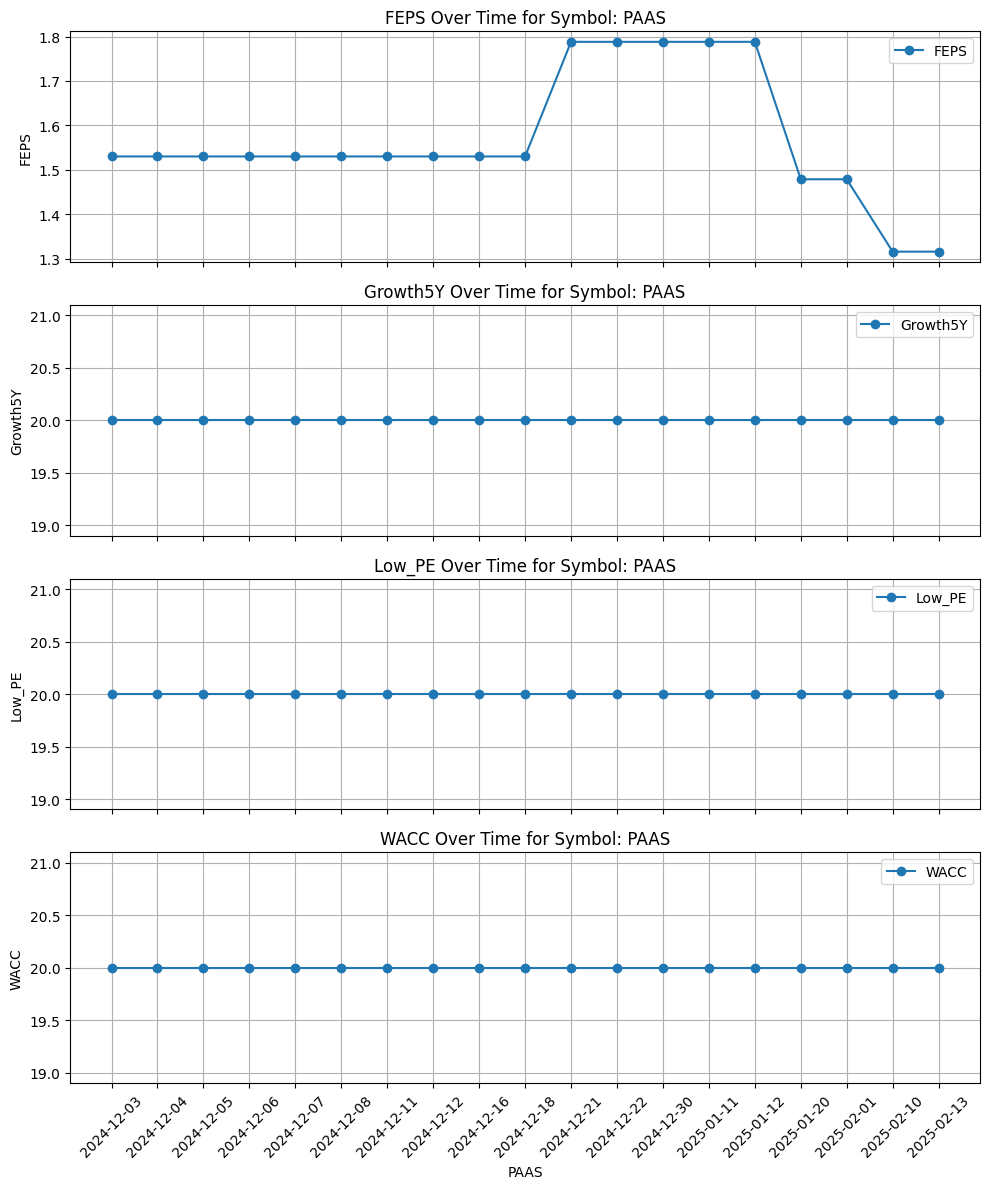

In [13]:
import sqlite3
import matplotlib.pyplot as plt

# Database path
db_path = "plan.db"

def plot_symbol_metrics(symbol):
    try:
        # Connect to the database
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()

            # Define the metrics to plot
            metrics = ["FEPS", "Growth5Y", "Low_PE", "WACC"]

            # Initialize a figure with subplots
            fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 12), sharex=True)

            for i, metric in enumerate(metrics):
                # Query the data for the current metric
                query = f"""
                SELECT Hdate, {metric} FROM HCValue WHERE Symbol = ? ORDER BY Hdate;
                """
                cursor.execute(query, (symbol,))
                data = cursor.fetchall()

                if not data:
                    print(f"No data found for Symbol: {symbol}, Metric: {metric}")
                    continue

                # Separate Hdate and metric values
                hdates, metric_values = zip(*data)

                # Plot the data on the current subplot
                axes[i].plot(hdates, metric_values, marker='o', linestyle='-', label=metric)
                axes[i].set_title(f"{metric} Over Time for Symbol: {symbol}")
                axes[i].set_ylabel(metric)
                axes[i].grid()
                axes[i].legend()

            # Set a shared X-axis label
            axes[-1].set_xlabel(symbol)
            plt.xticks(rotation=45)

            # Adjust layout for better spacing
            plt.tight_layout()
            plt.show()

    except sqlite3.Error as e:
        print(f"Error occurred: {e}")

# Example call
symbol_to_plot = "PAAS"
plot_symbol_metrics(symbol_to_plot)


In [4]:
import sqlite3
import pandas as pd

# 连接到 SQLite 数据库
conn = sqlite3.connect("plan.db")

# 查询数据
query = """
SELECT Symbol, FEPS, FFEPS, Hdate
FROM HCValue
"""
df = pd.read_sql_query(query, conn)

# 确保日期格式正确，并排序
df['Hdate'] = pd.to_datetime(df['Hdate'])
df = df.sort_values(by=['Symbol', 'Hdate'])

# 获取最新记录和历史记录
latest_data = df.groupby('Symbol').tail(1)
historical_data = df[~df.index.isin(latest_data.index)]

# 定义显著变化计算函数
def check_significant_change(symbol, latest_row, historical_data, threshold=0.05):
    hist = historical_data[historical_data['Symbol'] == symbol]
    if hist.empty:
        return None  # 跳过没有历史数据的记录

    # 计算历史最大值和最小值
    feps_max, feps_min = hist['FEPS'].max(), hist['FEPS'].min()
    ffeps_max, ffeps_min = hist['FFEPS'].max(), hist['FFEPS'].min()

    # 获取最新值
    latest_feps = latest_row['FEPS']
    latest_ffeps = latest_row['FFEPS']

    # 检查是否显著变化
    feps_significant = (
        latest_feps < feps_min * (1 - threshold) or
        latest_feps > feps_max * (1 + threshold)
    )
    ffeps_significant = (
        latest_ffeps < ffeps_min * (1 - threshold) or
        latest_ffeps > ffeps_max * (1 + threshold)
    )

    if feps_significant or ffeps_significant:
        return {
            "Symbol": symbol,
            "Hdate": latest_row['Hdate'],
            "FEPS_Change": latest_feps,
            "FFEPS_Change": latest_ffeps,
            "FEPS_Significant": feps_significant,
            "FFEPS_Significant": ffeps_significant,
        }
    return None

# 处理每个 Symbol
results = []
for _, latest_row in latest_data.iterrows():
    result = check_significant_change(
        latest_row['Symbol'], latest_row, historical_data, threshold=0.05
    )
    if result:
        results.append(result)

# 转换为 DataFrame，仅显示有显著变化的记录
results_df = pd.DataFrame(results)

# 打印结果
if not results_df.empty:
    results_df = results_df[["Symbol", "Hdate", "FEPS_Change", "FFEPS_Change"]]  # 规范表格格式
    print("\nSignificant Changes Detected:")
    print(results_df)
    #results_df.to_csv("significant_changes.csv", index=False)
    print("\nResults have been saved to 'significant_changes.csv'.")
else:
    print("\nNo significant changes detected.")

# 关闭数据库连接
conn.close()



Significant Changes Detected:
   Symbol      Hdate  FEPS_Change  FFEPS_Change
0     ADM 2025-02-13     4.266010      4.736350
1     ALB 2025-02-13    -0.656600      3.121360
2    ALGN 2025-02-13    10.056430     11.147960
3     ALL 2025-02-13    17.840870     21.306290
4    AMKR 2025-02-13     1.493130      2.065190
..    ...        ...          ...           ...
66   VIRT 2025-02-13     3.744830      3.878750
67     WY 2025-02-13     0.793580      1.082180
68      X 2025-02-13     2.027890      3.411670
69    XOM 2025-02-13     7.248290      8.766300
70   XPEV 2025-02-13    -0.565794     -0.213137

[71 rows x 4 columns]

Results have been saved to 'significant_changes.csv'.
